<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)
- Ordinal Encoding을 적용해 보세요.
- **(객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.**
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


# 1. Kaggle Colab Connection

In [1]:
# !pip install --upgrade pandas_profiling
# !pip install --upgrade category_encoders

In [2]:
# # connect kaggle colab
# !pip install kaggle
# from google.colab import files
# files.upload()

# # 파일이 제대로 업로드 되었는지 확인
# print('\n--------파일 제대로 업로드 되었는지 확인--------\n')
# !ls -1ha kaggle.json
# # 파일 업로드 제대로 되었는지 확인 완료!

# # kaggle API를 사용하기 위해 json 파일 ~/.kaggle로 이동
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기
# print('\n---------------내가 참가한 대회---------------\n') 
# !kaggle competitions list

# # 데이터 셋 불러오기
# print('\n------------upload dataset------------\n')
# !kaggle competitions download -c prediction-of-h1n1-vaccination

# 2. Data Preparation

In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split

target = 'vacc_h1n1_f'

X = pd.read_csv('/content/train.csv.zip')
X_test = pd.read_csv('/content/test.csv.zip')
y = pd.read_csv('/content/train_labels.csv').drop('vacc_seas_f',axis = 1)

# train, val split 
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size = .8,random_state = 2)

X_train.shape, X_val.shape, X_test.shape

((33723, 38), (8431, 38), (28104, 38))

# **Quiz. (객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.**
    
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


## Answer : 1번 


- 4개의 feature 중 opinion_h1n1_vacc_effective_categories가 ordinal encoding이 필요하다. 
- 해당 feature 내부의 category가 담고 있는 의미를 수치로 변환한다고
해도 원래 범주의 의미가 그대로 유지될 수 있다. 
- 그래서 ordinal encoding으로 바꿔주고 random forest 모델에 사용하는 것이 훨씬 성능 향상에 도움이 될 것이다.


In [4]:
# 다음 중 ordinal encoding이 필요한 feature는 ? opinion_h1n1_vacc_effective, state, marital, employment_occupation
for feature in ['opinion_h1n1_vacc_effective', 'state', 'marital', 'employment_occupation']:
  print(f'\n[{feature}_categories]: \n\nunique category:{X[feature].unique().tolist()}\nlen_unique_categories: {len(X[feature].unique().tolist())}\n---------------------------------')


[opinion_h1n1_vacc_effective_categories]: 

unique category:[nan, 'Very Effective', 'Somewhat Effective', 'Not Very Effective', 'Dont Know', 'Not At All Effective', 'Refused']
len_unique_categories: 7
---------------------------------

[state_categories]: 

unique category:['CALIFORNIA', 'NEBRASKA', 'MASSACHUSETTS', 'LOUISIANA', 'ALABAMA', 'MONTANA', 'MISSOURI', 'WISCONSIN', 'FLORIDA', 'MARYLAND', 'NEVADA', 'PENNSYLVANIA', 'RHODE ISLAND', 'ARIZONA', 'MAINE', 'SOUTH DAKOTA', 'WYOMING', 'CONNECTICUT', 'DELAWARE', 'NEW YORK', 'SOUTH CAROLINA', 'NEW JERSEY', 'NORTH CAROLINA', 'DISTRICTOF COLUMBIA', 'NEW HAMPSHIRE', 'TEXAS', 'OREGON', 'KENTUCKY', 'NORTH DAKOTA', 'TENNESSEE', 'INDIANA', 'WASHINGTON', 'MISSISSIPPI', 'WEST VIRGINIA', 'MINNESOTA', 'HAWAII', 'VIRGINIA', 'ARKANSAS', 'ALASKA', 'OKLAHOMA', 'KANSAS', 'NEW MEXICO', 'VERMONT', 'ILLINOIS', 'MICHIGAN', 'IDAHO', 'UTAH', 'GEORGIA', 'IOWA', 'OHIO', 'COLORADO']
len_unique_categories: 51
---------------------------------

[marital_categorie

# EDA

In [5]:
# categorical features 확인
X_train.describe(exclude = 'number')

,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,employment_status,census_msa,employment_industry,employment_occupation,state
count,26688,26651,26615,26562,26501,26453,33723,25457,33723,13782,13782,33723
unique,6,6,6,6,6,6,7,3,3,23,25,51
top,Somewhat Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Somewhat Low,Not At All Worried,65+ Years,Employed,"MSA, Not Principle City",Health Care and Social Assistance Industries,Management Occupations,TEXAS
freq,11732,10013,9273,11661,9130,11778,6752,13788,15229,2481,1732,818


In [6]:
X_train.head(10)
print(X_train[X_train.employment_status == 'Not in Labor Force'].employment_industry.value_counts())
print(X_train[X_train.employment_status == 'Not in Labor Force'].employment_occupation.value_counts())
print(X_train[X_train.employment_status == 'Not in Labor Force'].shape)

Series([], Name: employment_industry, dtype: int64)
Series([], Name: employment_occupation, dtype: int64)
(10178, 38)


# Decision 

- seasonal flu vaccine와 관련된 feature 삭제 필요.(seasonal flu vaccine를 받았는지 안 받았는지에 대한 target value는 사용 x)
    - features: `doctor_recc_seasonal`, `opinion_seas_vacc_effective`, `opinion_seas_risk`, `opinion_seas_sick_from_vacc`
    - 총 4개의 feature 삭제 필요.

- 새로운 feature 생성 필요.
  - behavioral를 갖고 있는 features를 합해서 새로운 feature 생성[behaviorals]
    - 각 관측치마다 몇 가지의 행동을 하는지 확인 가능

- employment_status == 'Not in Labor Force' 인 observations에서 employment_industry와 employment_occupation의 값을 보았는데 모두 다 NaN값이었다. 
  - 내가 해석하기론, Not in Labor Force 자체가 말 그대로 노동 인력이 아니기 때문에 해당 직장의 산업과 직업에 대한 정보가 결측값으로 표현된 것 같다. 따라서, simpleImputer로 결측값을 수정하는 것은 의미가 없다고 판단되고 이러한 관측값이 총 1만개(train data의 대략 1/3)가 넘어가기 때문에 drop 하는 것도 힘들다.
  - 따라서, employment_industry와 employment_occupation feature drop하기로 결정

# Feature Engineering

In [7]:
## feature engineering
from category_encoders import OneHotEncoder

def change(x):
  if int(x) > 0 :
    return 0
  else:
    return 1

def f_engineering(df):
  #drop high cardinality feature - state
  select_columns = df.select_dtypes(include = ['number','object'])
  labels = select_columns.nunique()
  select_features = labels[labels<=30].index.tolist()
  df = df[select_features]

  # behaviorals feature 생성
  behaviorals = [col for col in df.columns if 'behavioral' in col]
  df['behaviorals'] = df.loc[:,behaviorals].sum(axis = 1)

  # n_adult_r feature 삭제, household_children & n_people_r 두 가지 feature와 다중 공산성 문제가 발생할 수 있다고 판단.
  df.drop('n_adult_r',axis=1)

  # 건강보험이 있는 workers 
  workers_h_insurances = ['health_insurance','health_worker']
  df['workers_have_insurances'] = df.loc[:,workers_h_insurances].sum(axis = 1)
  df['workers_have_insurances'] = df['workers_have_insurances'].apply(change)

  # seas & employment가 들어 있는 feature 제거 
  dels = [col for col in df.columns if ('employment_industry' in col or 'employment_occupation' in col or 'seas' in col)] # employment와 seas를 가지고 있는 특성을 모두 제거
  df.drop(columns=dels, inplace=True)

  return df 

X_train = f_engineering(X_train)
X_val = f_engineering(X_val)
X_test = f_engineering(X_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요.
- 랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 이유를 본인 논리로 분석해 보세요.
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [8]:
## Ordinal Encoder에 사용할 mapping 값 지정
# opinion_h1n1_vacc_effective, opinion_h1n1_risk,	opinion_h1n1_sick_from_vacc ,agegrp	지정 

# mapping 해주려면 아싸리 다 해줘야 되는구나.. 다 안해주면 오류가 발생하네 혹은 encoder parameter를 조정해주던가.
# mapping = [{'col' : 'opinion_h1n1_vacc_effective', 'mapping' : {'Very Effective':6, 'Somewhat Effective':5, 'Dont Know':4, 'Not Very Effective':3, 'Not At All Effective':2, 'Refused':1}},
#            {'col' : 'opinion_h1n1_risk', 'mapping' : {'Very High':6, 'Somewhat Effective':5, 'Dont Know':4, 'Somewhat Low':3, 'Very Low':2, 'Refused':1}},
#            {'col':'opinion_h1n1_sick_from_vacc','mapping' : {'Very Worried':6, 'Somewhat Worried':5, 'Dont Know':4, 'Not Very Worried':3, 'Not At All Worried':2, 'Refused':1}},
#            {'col' : 'agegrp','mapping': {'6 Months - 9 Years':1, '10 - 17 Years':2, '18 - 34 Years':3, '35 - 44 Years':4, '45 - 54 Years':5, '55 - 64 Years':6, '65+ Years':7}},
#            {'col' : 'employment_status','mapping':{'Not in Labor Force':0,'Unemployed':1,'Employed':2}}]

In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import f1_score

# ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1
                           , oob_score=True,max_features = 'log2'
                           ,max_depth = 18,min_samples_split = 80)
    )

pipe_ord.fit(X_train, y_train)

print('훈련 정확도: ', pipe_ord.score(X_train, y_train)) 
print('검증 정확도', pipe_ord.score(X_val, y_val))
print('F1-Score for valid :', f1_score(y_val, pipe_ord.predict(X_val)))
print(f'out-of-bag samples accuracy: ' ,pipe_ord.named_steps['randomforestclassifier'].oob_score_)
print()

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


훈련 정확도:  0.839041603653293
검증 정확도 0.8282528762898825
F1-Score for valid : 0.559610705596107
out-of-bag samples accuracy:  0.8266465023870948

CPU times: user 6.24 s, sys: 149 ms, total: 6.39 s
Wall time: 4.13 s


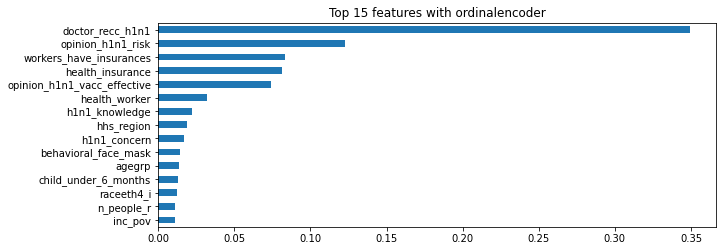

In [10]:
## 특성 중요도 파악
import matplotlib.pyplot as plt

n = 15

rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

In [11]:
y_pred = pipe_ord.predict(X_test)
my_submission = pd.DataFrame({
    'Id' : range(0, len(y_pred)),
    'vacc_h1n1_f' : y_pred})
my_submission
my_submission.to_csv('my_submission.csv', index=False)

# 결론
- 총 3번의 제출을 시도했고 결과는 0.53 에서 최종은 0.52825의 결과를 얻을 수 있었다. 가장 어려웠던 것은 Randomforestclassifier의 **Hyper Parameter**를 수정하는 일이었다. 

- 결과가 decision tree를 이용했을 때보다 0.3나 더 낮은 결과가 나왔다. 이유로는 많은 이유가 있겠지만, 데이터의 전처리 과정이 완벽하지 못했을수도 있다는 생각도 든다. 또한 모델의 성능의 높여주는 최적화된 하이퍼 파라미터를 찾지 못해서라고 생각한다. 이러한 이유로 일반화가 제대로 이루어지지 못해서 최적화된 모델을 찾지 못했고 이에 따라 성능이 저조하다고 생각했다.

## 🔥 도전과제

### 3) 수업에 사용하지 않은 다른 종류의 [category_encoders](http://contrib.scikit-learn.org/category_encoders/)을 적용해 보고 인코더에 대해 설명하세요

#### Binary Encoder 사용
- 해당 범주를 범주의 수에 해당하는 범위에 맞게 수치로 encoding하고 해당 수치를 이진수로 표현해주는 encoder이다.

In [12]:
%%time
from category_encoders import  BinaryEncoder

# binary encoding
pipe_bi = make_pipeline(
    BinaryEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1
                           , oob_score=True,max_features = 'log2'
                           ,max_depth = 18,min_samples_split = 80)
    )

pipe_bi.fit(X_train, y_train)

print('훈련 정확도: ', pipe_bi.score(X_train, y_train)) 
print('검증 정확도', pipe_bi.score(X_val, y_val))
print('F1-Score for valid :', f1_score(y_val, pipe_bi.predict(X_val)))
print(f'out-of-bag samples accuracy: ' ,pipe_bi.named_steps['randomforestclassifier'].oob_score_)
print()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


훈련 정확도:  0.8339412270557186
검증 정확도 0.8246945795279327
F1-Score for valid : 0.5334595959595959
out-of-bag samples accuracy:  0.8245411143729798

CPU times: user 6.6 s, sys: 159 ms, total: 6.76 s
Wall time: 4.57 s


In [13]:
# Binary Encoder vs Ordinal Encoder
print('\n--------Binary Encoder 사용--------')
print('검증 정확도', pipe_bi.score(X_val, y_val))
print('F1-Score for valid :', f1_score(y_val, pipe_bi.predict(X_val)))

print('\n--------Ordinal Encoder 사용--------')
print('검증 정확도', pipe_ord.score(X_val, y_val))
print('F1-Score for valid :', f1_score(y_val, pipe_ord.predict(X_val)))


--------Binary Encoder 사용--------
검증 정확도 0.8246945795279327
F1-Score for valid : 0.5334595959595959

--------Ordinal Encoder 사용--------
검증 정확도 0.8282528762898825
F1-Score for valid : 0.559610705596107


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


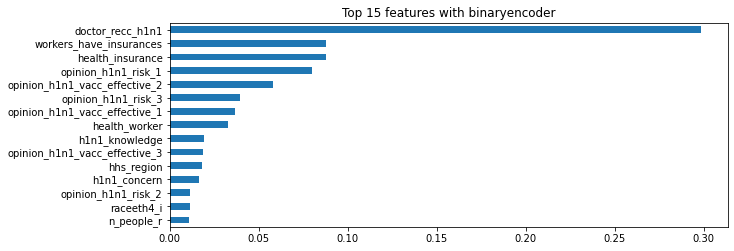

In [16]:
# 특성 중요도 파악

bi_encoded_train = BinaryEncoder().fit_transform(X_train)
rf_bi = pipe_bi.named_steps['randomforestclassifier']
importances_bi = pd.Series(rf_bi.feature_importances_, bi_encoded_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with binaryencoder')
importances_bi.sort_values()[-n:].plot.barh();

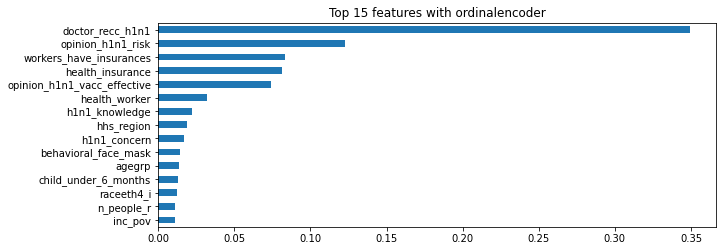

In [17]:
rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)